In [ ]:
!pip install tensorflow_text
!pip install contractions

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan  9 18:31:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import contractions
import pickle

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from nltk.tokenize import RegexpTokenizer

from keras.layers import Input,Dropout,Dense, LSTM, TextVectorization, Embedding
from keras import Model, Sequential
from  keras.models import load_model
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

# Modeling and Predictions

In [23]:
#read in file
wine = pd.read_csv('data/2022_winemag_reviews.csv')

### Model features and targets preperation
- For modeling, I will only be using the sommelier's reviews to predict wine variety. Seen in the wine description EDA, TDIF vocabularies and Word2Vec word similarities show significant information and are capable of being a predictive feature for modeling variety. Because of the large range of varieties, I will simplify the target variables based on specific grape varieties, excluding blends, and only chosing varieties that have atleast 700 samples.

In [24]:
#feature and labels from the dataset
model_df = wine[['description','variety']]

#Drop any varieties that contains a blend, better for classifying specific grapesa
model_df = model_df[~model_df['variety'].str.contains("Blend")]

#creating a list of the varieties with sufficient data 
variety_700 = model_df['variety'].value_counts()[model_df['variety'].value_counts() >= 700].keys()

#condensing data to only contain those varieties 
condensed_model_df = model_df[model_df['variety'].isin(variety_700)]
print(condensed_model_df.variety.value_counts())

#creating a class output variable for modeling later on
class_outputs = len(condensed_model_df['variety'].unique())

Pinot Noir            2458
Chardonnay            1912
Cabernet Sauvignon    1832
Gamay                  907
Sangiovese             887
Sauvignon Blanc        882
Portuguese Red         861
Rosé                   825
Syrah                  700
Name: variety, dtype: int64


- The most popular wine varieties have far more wine reviews than the others. To help with the classification modeling, the target labels will undersampled to match the minority group total. This equalization will remove any skew the modelings that may occur in favor of the majority class. Imblearn library makes this easy with the RandomUnderSampler object. After undersampling, the target labels will be encoded in preperation for modeling with Sklearn's Label Encoder Object. The encoded varieties will be saved to a dictionary for decoding after modeling.

In [25]:
#undersample based on the minority group ('Syrah')
undersample = RandomUnderSampler(sampling_strategy='not minority')

#fit to the data
under_sampled = undersample.fit_resample(condensed_model_df[['description']],condensed_model_df[['variety']])

#merge the undersampled data into one 
under_sampled_df = pd.merge(left = under_sampled[0],right = under_sampled[1],right_index=True,left_index=True)

#instantiates label encoder 
le = LabelEncoder()

#create new target column for encoded variable
under_sampled_df['encoded_variety'] = le.fit_transform(under_sampled_df['variety'])

#decoding dictionary for predictions
mapping = dict(zip(range(len(le.classes_)),le.classes_))

#show new value counts for each target variable
under_sampled_df.groupby('encoded_variety')['variety'].value_counts()

encoded_variety  variety           
0                Cabernet Sauvignon    700
1                Chardonnay            700
2                Gamay                 700
3                Pinot Noir            700
4                Portuguese Red        700
5                Rosé                  700
6                Sangiovese            700
7                Sauvignon Blanc       700
8                Syrah                 700
Name: variety, dtype: int64

### Standardize Text
- The description for each wine will need to be standardized again for baseline modeling with Naive Bayes. The text will be striped of any punctuation, numbers, lowered in case, and tonkenized. Then the text will be put through TFID vectorizor before the naive bayes model. 

In [157]:
#standardization function
def standardization(input_data):
    regex = RegexpTokenizer(r'[\w\'\']+')

    conctract = contractions.fix(input_data)
    no_num = re.sub(r'\d+', '', conctract)
    tokens = regex.tokenize(no_num.lower())
    
    return " ".join(tokens)

#save formated text to new column 
under_sampled_df['text'] = under_sampled_df['description'].apply(standardization)

#Total amount of unique()
raw_text = ''
for text in under_sampled_df['text']:
    raw_text += text
word_count = len(set(raw_text.split()))
print('Unique words:',word_count)
print('Max Length:',max(under_sampled_df['text'].apply(len)))

Unique words: 9499
Max Length: 671


### Train/Test
- Split the data 75/25 and stratify target variables so that there is equal distribution. 

In [304]:
#Split variables to x and y
X = under_sampled_df[['text']]
y = under_sampled_df['encoded_variety']

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)

### Multinomial Naive Bayes
 - The basic model will be Multinomial Naive Bayes. This model uses Bayes Theorm of Probability which calculates the probability of an event occurring based on the prior knowledge of conditions. This modeling type is typically used for NLP classification due for simple, fast, and efficient computing power. This will be compared to Neural Nets to show if a larger pre-trained model will improve classification accuracy.
 - The Term Frequency Inverse Document Frequency (TFID) vectorizer to transform text into a vector that can actually be interpretted by the model. The text is counted, indexed, and based on the frequency and inverse document frequency of the word over the entire range of documents, is converted to a vector. All stop words are removed since these tend to not relate to the important context of each document. 

In [243]:
#vectorizer and model used in the grid search
tfid = TfidfVectorizer(stop_words='english',max_features=5000,ngram_range=(1, 3),max_df=.6)
mn = MultinomialNB()


#params for gridsearch
params = {
          'mn__alpha':[.3,.9,1]
         }
         
#put put everthing together in a pipeline
pipe_nb = Pipeline([
    ('tfid',tfid),
    ('mn',mn)])

#run gridsearch with pipe and param grid
grid_nb = GridSearchCV(
    estimator=pipe_nb, 
    param_grid=params,
    scoring='accuracy',
    cv = 5,
    n_jobs=-1)

#fit the model to the text only data because of the MultinomialNB can't have negative numbers
grid_nb.fit(X_train,y_train)

#print best params,accuracy scores,and confusion matrix
print(grid_nb.score(X_train,y_train))
print(grid_nb.score(X_test,y_test))

0.9075132275132275
0.819047619047619


### Sequential Model with Embedding
- In this model, text will again be vectorized but instead with Keras.text and a sequential recurrent neural net model. Each description is standardized (lowercased and punctuation removed), split,  recombined as ngrams, indexed, and vectorized. This model is strictly bound by the words within the data corpus. This is limited in the scope and contextual relation. 
- Once vectorized, the embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. Then the vectors are fed through an LSTM layer, Dense, and Dropout layers. This model under performs to the Naive Bayes due to the limited context of the vocabulary and vector relations. Using the BERT model is intended to help by adding a larger and more complex vocabulary in terms of vocabulary depth, word relationships, and the resulting vectors. 

In [305]:
vectorize_layer = TextVectorization(max_tokens=6000,output_sequence_length=500)
vectorize_layer.adapt(X_train)

In [306]:
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(Embedding(input_dim = len(vectorize_layer.get_vocabulary()),
                    output_dim = 64,
                    mask_zero = True))
model.add(LSTM(64))
model.add(Dropout(.4))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(.4))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(class_outputs, activation='softmax',name='output'))

#model summary
model.summary() 

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_12 (Text  (None, 500)              0         
 Vectorization)                                                  
                                                                 
 embedding_21 (Embedding)    (None, 500, 64)           383104    
                                                                 
 lstm_12 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                     

In [309]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics = 'accuracy')

In [310]:
history = model.fit(X_train,y_train,validation_split=.2,batch_size = 128, epochs=10)

Epoch 1/10
30/30 [==============================] - 21s 537ms/step - loss: 2.1865 - accuracy: 0.1566 - val_loss: 2.1509 - val_accuracy: 0.2138
Epoch 2/10
30/30 [==============================] - 15s 487ms/step - loss: 1.9757 - accuracy: 0.2246 - val_loss: 1.7741 - val_accuracy: 0.2762
Epoch 3/10
30/30 [==============================] - 15s 496ms/step - loss: 1.6325 - accuracy: 0.3622 - val_loss: 1.4734 - val_accuracy: 0.4180
Epoch 4/10
30/30 [==============================] - 14s 475ms/step - loss: 1.3065 - accuracy: 0.4479 - val_loss: 1.2430 - val_accuracy: 0.5376
Epoch 5/10
30/30 [==============================] - 15s 486ms/step - loss: 1.1087 - accuracy: 0.5288 - val_loss: 1.1607 - val_accuracy: 0.5418
Epoch 6/10
30/30 [==============================] - 15s 488ms/step - loss: 0.9236 - accuracy: 0.6233 - val_loss: 1.0640 - val_accuracy: 0.6042
Epoch 7/10
30/30 [==============================] - 14s 473ms/step - loss: 0.8057 - accuracy: 0.6767 - val_loss: 0.9870 - val_accuracy: 0.6825

### Bert Pre-Trained Model
- BERT, Bidirectional Encoder Representations from Transformers, is Google's pretrained transformer model that has a vareitiy of NLP applications. Trained on over 3,300 million words it is better equiped to understand contextial relationships during vectorization. Using raw text as input, BERT's transformer will pre-process and encode through its pre-trained library. This model has been nicely ported in Keras for use as fine-tuned model like classifying wine varieties. 
- To further increase the performance of the model, an optimizier scheduler was used to decay learning rate of the model over the training time. This is done using the PolynomialDecay and applying through the Adam optimizer. 

In [ ]:
#Keras hub URL that contain both the BERT preprocessing moduel and connected encoding model. 
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

#create the BERT layers
bert_preprocess = hub.KerasLayer(preprocess_url, name = 'preprocessing')
bert_encoder = hub.KerasLayer(encoder_url,trainable=True, name ='Bert_encoding')

#test out encoding and preprocessing
# def get_sentence_embeding(text):
#     preprocess_test = bert_preprocess([text])
#     return bert_encoder(preprocess_test)['pooled_output']

# x = get_sentence_embeding(X_train.iloc[200]['description'])

In [108]:
#bert layers
text_input = Input(shape=(),dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#neural net layers
dropout = Dropout(.4)(outputs['pooled_output'])
dense = Dense(16,activation='relu')(dropout)
dense = Dense(class_outputs, activation='softmax',name='output')(dense)

#construct mode
model = Model(inputs = [text_input], outputs=[dense])

#model summary
model.summary() 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
#create a polyninnomal decay(in this case linear decay) for learning rate over the entire training 
batch_size = 64
num_epochs = 5
num_train_steps = (len(y_train) * num_epochs)
lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
                               end_learning_rate = 0.,
                               decay_steps = num_train_steps)

#apply the scheduler to the Adam Optimizier
opt = Adam(learning_rate=lr_scheduler)

#complie the model with the newly optimizer variable
model.compile(optimizer=opt,
             loss='sparse_categorical_crossentropy',
             metrics = 'accuracy')

In [75]:
#fit the model 
history = model.fit(X_train,y_train,validation_split=.2, epochs=num_epochs)

Epoch 1/5
119/119 [==============================] - 144s 913ms/step - loss: 0.9178 - accuracy: 0.7230 - val_loss: 0.4225 - val_accuracy: 0.8794
Epoch 2/5
119/119 [==============================] - 107s 903ms/step - loss: 0.3866 - accuracy: 0.8878 - val_loss: 0.3717 - val_accuracy: 0.8952
Epoch 3/5
119/119 [==============================] - 107s 902ms/step - loss: 0.2200 - accuracy: 0.9421 - val_loss: 0.4149 - val_accuracy: 0.8847
Epoch 4/5
119/119 [==============================] - 108s 905ms/step - loss: 0.1471 - accuracy: 0.9577 - val_loss: 0.4214 - val_accuracy: 0.8899
Epoch 5/5
119/119 [==============================] - 107s 901ms/step - loss: 0.1119 - accuracy: 0.9688 - val_loss: 0.4412 - val_accuracy: 0.8899


In [184]:
model.evaluate(X_test,y_test)

50/50 [==============================] - 379s 8s/step - loss: 0.4409 - accuracy: 0.8775


[0.4408557415008545, 0.8774603009223938]

In [ ]:
#y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

[]

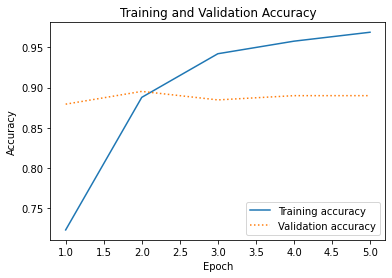

In [ ]:
#show accuracy graphs from model
acc = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [119]:
#testing out the prediction with tasting notes and decoding prediction with dictionary mapping
ans = model.predict(['cherry and tobacco'])
idx = np.argmax(ans)
print(mapping[idx])

1/1 [==============================] - 2s 2s/step
Cabernet Sauvignon


In [ ]:
#save model to reload in the streamlit app
#model.save('/content/gdrive/MyDrive/GA - DSIR 1010/model')

### Conclusions

Overall, the BERT model increased accuracy by almost 10% from the Naive Bayes at a trade off of increased computing power and total memory needed to store the model for deployment. This was a great exercise but would definitly improve with more data. Ideally, all 400+ types of grapes could be identified and classifiied based on reviwes but it is beyond the scope and time constraints of the project. 

Improved text preprocessing could also help in the classification. Some data leakage occured since names of the grapes were mentioned within the review. Being able to remove this and focus on specific defining characteristics would help improve performance. 